<a href="https://colab.research.google.com/github/kamalmango/pneumonia-detection/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization, Dense
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.optimizers import RMSprop, Adam
from random import randint
import cv2

In [2]:
os.environ['KAGGLE_USERNAME'] = 'xxxxxx'
os.environ['KAGGLE_KEY'] = 'xxxxxxxxxxxxxxxxxx'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:19<00:00, 64.8MB/s]
100% 1.15G/1.15G [00:19<00:00, 64.6MB/s]


In [3]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          
Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/

In [0]:
train_files = "./chest_xray/train/"
test_files = "./chest_xray/test/"
validation_files = "./chest_xray/val"

In [12]:
# number of xrays which show pneumonia
p = Path(train_files + "PNEUMONIA" + "/")
x = list(p.glob("*.jpeg"))
print("Training-Pneumonia - %i " % len(x))

# number of xreays which show normal
p = Path(train_files + "NORMAL" + "/")
x = list(p.glob("*.jpeg"))
print("Training-Normal - %i " % len(x))

Training-Pneumonia - 3875 
Training-Normal - 1341 


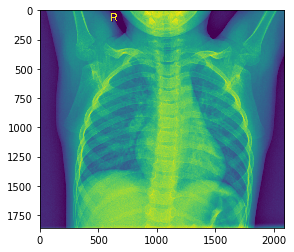

In [13]:
# check out data/ images
img = mpimg.imread(train_files + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

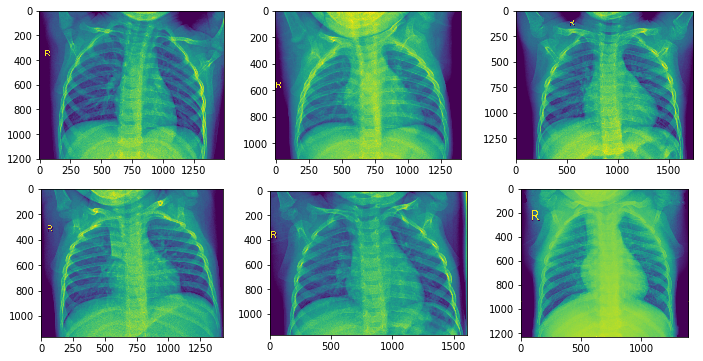

In [15]:
plot_images(train_files + '/NORMAL')

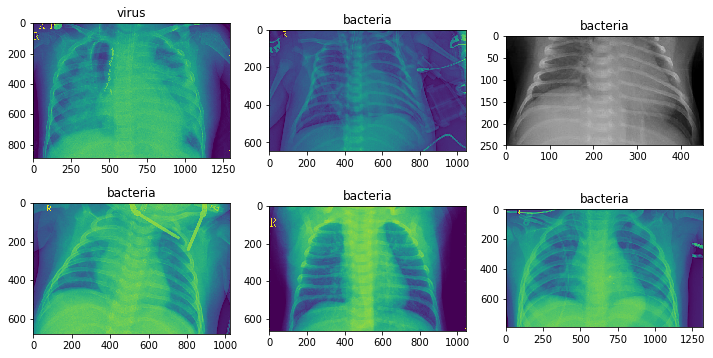

In [17]:
plot_images(train_files + '/PNEUMONIA', labeled=True)

In [43]:
#train the model
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    train_files,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_files,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_files,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)



Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [47]:
# modify inception v3 CNN 
base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
base_model.trainable = False
model = Sequential([base_model,
                    GlobalAveragePooling2D(),
                    Dense(1024, activation = "relu"),
                    BatchNormalization(),
                    Dense(2, activation='softmax')])

model.compile(Adam(0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_568 (Bat (None, 1024)              4096      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 2050      
Total params: 23,907,106
Trainable params: 2,102,274
Non-trainable params: 21,804,832
_________________________________________________________________


In [49]:
#train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/5
163/163 [==============================] - 288s 2s/step - loss: 0.3824 - acc: 0.8622 - val_loss: 1.8509 - val_acc: 0.6250
Epoch 2/5
163/163 [==============================] - 275s 2s/step - loss: 0.2666 - acc: 0.8926 - val_loss: 1.8184 - val_acc: 0.6875
Epoch 3/5
163/163 [==============================] - 278s 2s/step - loss: 0.2576 - acc: 0.8949 - val_loss: 2.9679 - val_acc: 0.5625
Epoch 4/5
163/163 [==============================] - 279s 2s/step - loss: 0.2464 - acc: 0.9045 - val_loss: 1.3805 - val_acc: 0.7500
Epoch 5/5
163/163 [==============================] - 279s 2s/step - loss: 0.2476 - acc: 0.8995 - val_loss: 1.1305 - val_acc: 0.8125


In [50]:
# evaluate the model
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

624/624 [==============================] - 50s 81ms/step - loss: 1.0051 - acc: 0.7099
Loss: 1.0050843514495216
Accuracy: 0.7099359


In [0]:
y = test_generator.classes
yhat = model.predict_generator(test_generator,
                                 steps = len(test_generator),
                                 verbose = 0)


In [62]:
y_img_batches = []
y_pred_batches = []
y_true_batches = []

for i in range(0, len(test_generator)):
  
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),

In [0]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

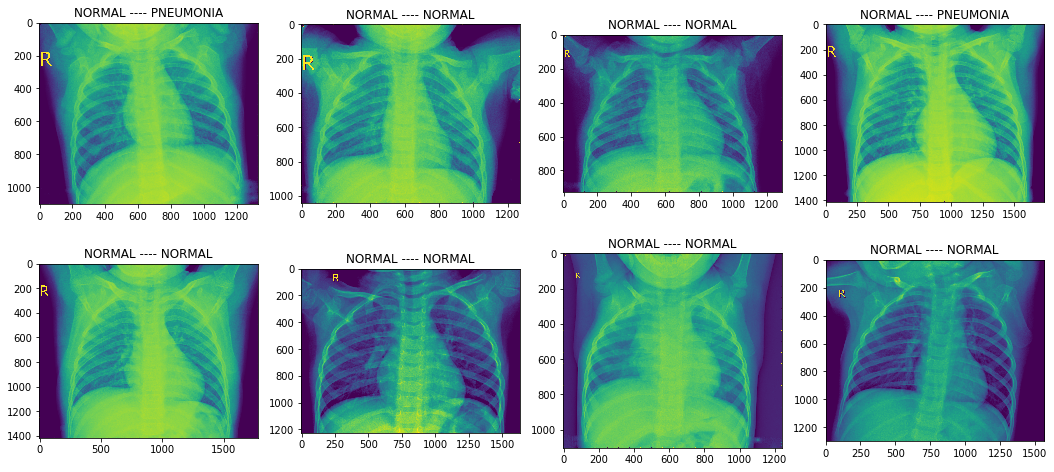

In [57]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

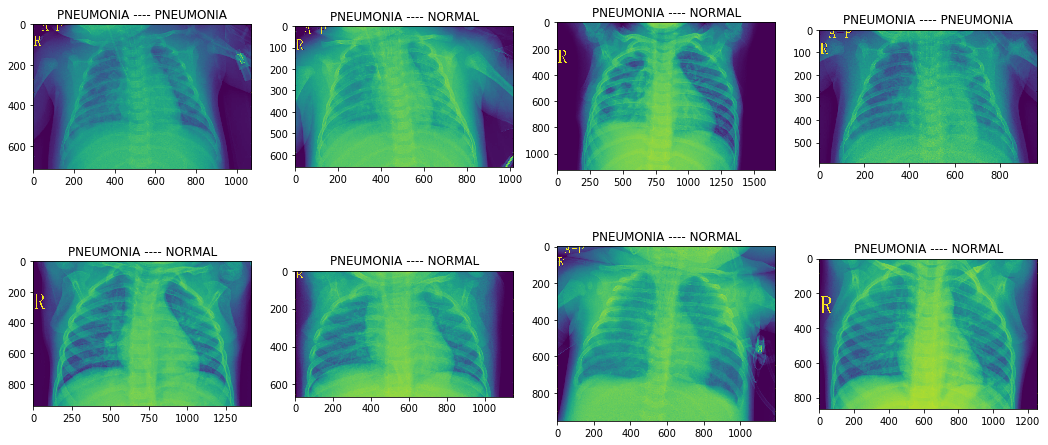

In [58]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

In [0]:
model.save('updated_model.h5')